In [1]:
import os
import json
import pandas as pd
from pathlib import Path

base_dir = Path("/Users/sebastian/Documents/Bachelor Thesis/sparql-rag-agent/sparql-rag-agent/experiments/experiments_official")

experiment_mapping = {
    "multi_run_2025-05-02_00-31-21": "CP-A",  
    "multi_run_2025-05-04_00-51-30": "few-shot CoT",     
    "multi_run_2025-05-06_22-14-46": "LtM",
    "multi_run_2025-05-10_14-26-00": "Baseline",
    "multi_run_2025-05-10_18-05-54": "CP",
    "multi_run_2025-05-11_00-21-16": "CoT",
}

multi_run_dirs = [d for d in base_dir.glob("multi_run_*") if d.is_dir()]
print(f"Found {len(multi_run_dirs)} multi-run directories: {[d.name for d in multi_run_dirs]}")

# To store results
results = []

for dir_path in multi_run_dirs:
    experiment_name = experiment_mapping.get(dir_path.name, dir_path.name)
    print(f"\nProcessing experiment: {experiment_name} ({dir_path.name})")
    
    # Find all run directories (run_1, run_2, etc.)
    run_dirs = [d for d in dir_path.glob("run_*") if d.is_dir()]
    print(f"  Found {len(run_dirs)} run directories")
    
    for run_dir in run_dirs:
        # Find the evaluation directory (ev_*)
        eval_dirs = [d for d in run_dir.glob("ev_*") if d.is_dir()]
        
        if not eval_dirs:
            print(f"  × No evaluation directory found in {run_dir.name}")
            continue
            
        eval_dir = eval_dirs[0]  # There should be only one
        metrics_file = eval_dir / "metrics_dataset.json"
        
        if metrics_file.exists():
            try:
                with open(metrics_file, 'r') as f:
                    metrics_data = json.load(f)
                    
                # Check for the specific metric
                metric_value = metrics_data.get("number_of_query_results_evaluated_excluding_empty_result", 0)
                
                if metric_value != 0:
                    result = {
                        "experiment": experiment_name,
                        "multi_run_dir": dir_path.name,
                        "run_dir": run_dir.name,
                        "eval_dir": eval_dir.name,
                        "metric_value": metric_value
                    }
                    results.append(result)
                    print(f"  • {run_dir.name}: metric = {metric_value}")
            except Exception as e:
                print(f"  × Error processing {metrics_file}: {e}")
        else:
            print(f"  × File not found: {metrics_file}")

# Summary of findings
if results:
    print("\n--- SUMMARY OF NON-ZERO METRICS ---")
    for result in results:
        print(f"Experiment '{result['experiment']}' ({result['multi_run_dir']}), "
              f"{result['run_dir']}: "
              f"number_of_query_results_evaluated_excluding_empty_result = {result['metric_value']}")
else:
    print("\nNo non-zero 'number_of_query_results_evaluated_excluding_empty_result' metrics found.")
df_results = pd.DataFrame(results)

Found 6 multi-run directories: ['multi_run_2025-05-11_00-21-16', 'multi_run_2025-05-04_00-51-30', 'multi_run_2025-05-10_18-05-54', 'multi_run_2025-05-06_22-14-46', 'multi_run_2025-05-10_14-26-00', 'multi_run_2025-05-02_00-31-21']

Processing experiment: CoT (multi_run_2025-05-11_00-21-16)
  Found 10 run directories
  • run_2: metric = 1
  • run_5: metric = 1
  • run_4: metric = 1
  • run_3: metric = 2
  • run_10: metric = 1
  • run_6: metric = 1
  • run_1: metric = 1
  • run_8: metric = 1
  • run_9: metric = 1

Processing experiment: few-shot CoT (multi_run_2025-05-04_00-51-30)
  Found 10 run directories
  • run_2: metric = 4
  • run_5: metric = 3
  • run_4: metric = 6
  • run_3: metric = 3
  • run_10: metric = 4
  • run_6: metric = 4
  • run_1: metric = 4
  • run_8: metric = 5
  • run_9: metric = 6
  • run_7: metric = 5

Processing experiment: CP (multi_run_2025-05-10_18-05-54)
  Found 10 run directories
  • run_2: metric = 2
  • run_5: metric = 2
  • run_4: metric = 2
  • run_3: metr

In [2]:
import os
import json
import pandas as pd
from pathlib import Path
from datetime import datetime

# Base directory where all experiment results are stored
base_dir = Path("/Users/sebastian/Documents/Bachelor Thesis/sparql-rag-agent/sparql-rag-agent/experiments/experiments_official")

# Mapping of directory names to methodology names
methodology_mapping = {
    "multi_run_2025-05-02_00-31-21": "CP-A",  
    "multi_run_2025-05-04_00-51-30": "few-shot CoT",     
    "multi_run_2025-05-06_22-14-46": "LtM",
    "multi_run_2025-05-10_14-26-00": "Baseline",
    "multi_run_2025-05-10_18-05-54": "CP",
    "multi_run_2025-05-11_00-21-16": "CoT",
}

# Find all multi-run directories
multi_run_dirs = [d for d in base_dir.glob("multi_run_*") if d.is_dir()]
print(f"Found {len(multi_run_dirs)} multi-run directories: {[d.name for d in multi_run_dirs]}")

# To store results from all experiments
all_data = []

# Process each multi-run directory
for multi_run_dir in multi_run_dirs:
    multi_run_name = multi_run_dir.name
    methodology = methodology_mapping.get(multi_run_name, multi_run_name)
    print(f"\nProcessing multi-run: {multi_run_name} (Methodology: {methodology})")
    
    # Find all run directories (run_1, run_2, etc.)
    run_dirs = [d for d in multi_run_dir.glob("run_*") if d.is_dir()]
    print(f"Found {len(run_dirs)} run directories")
    
    for run_dir in run_dirs:
        run_name = run_dir.name
        
        # Find evaluation directories
        eval_dirs = [d for d in run_dir.glob("ev_*") if d.is_dir()]
        
        if not eval_dirs:
            print(f"  × No evaluation directory found in {run_name}")
            continue
            
        # Process each evaluation directory
        for eval_dir in eval_dirs:
            eval_timestamp = eval_dir.name.replace("ev_", "")
            eval_dataset_file = eval_dir / "evaluation_dataset.json"
            
            if not eval_dataset_file.exists():
                print(f"  × Evaluation dataset file not found in {eval_dir.name}")
                continue
                
            print(f"  • Processing {run_name}/{eval_dir.name}")
            
            try:
                # Load the evaluation dataset
                with open(eval_dataset_file, 'r') as f:
                    eval_data = json.load(f)
                
                # For each item in the evaluation dataset, add metadata
                for item in eval_data:
                    item["methodology"] = methodology
                    item["multi_run_dir"] = multi_run_name
                    item["eval_dir"] = eval_dir.name
                    all_data.append(item)
                    
                print(f"    ✓ Added {len(eval_data)} items from dataset")
                
            except Exception as e:
                print(f"  × Error processing {eval_dataset_file}: {e}")


df = pd.DataFrame(all_data)
    

Found 6 multi-run directories: ['multi_run_2025-05-11_00-21-16', 'multi_run_2025-05-04_00-51-30', 'multi_run_2025-05-10_18-05-54', 'multi_run_2025-05-06_22-14-46', 'multi_run_2025-05-10_14-26-00', 'multi_run_2025-05-02_00-31-21']

Processing multi-run: multi_run_2025-05-11_00-21-16 (Methodology: CoT)
Found 10 run directories
  • Processing run_2/ev_2025-05-11_00-28-57
    ✓ Added 32 items from dataset
  • Processing run_5/ev_2025-05-11_02-25-26
    ✓ Added 32 items from dataset
  • Processing run_4/ev_2025-05-11_01-22-23
    ✓ Added 32 items from dataset
  • Processing run_3/ev_2025-05-11_00-57-28
    ✓ Added 32 items from dataset
  • Processing run_10/ev_2025-05-12_04-07-17
    ✓ Added 32 items from dataset
  • Processing run_6/ev_2025-05-12_02-40-23
    ✓ Added 32 items from dataset
  • Processing run_1/ev_2025-05-12_00-25-08
    ✓ Added 32 items from dataset
  • Processing run_8/ev_2025-05-11_09-54-17
    ✓ Added 32 items from dataset
  • Processing run_9/ev_2025-05-11_10-20-40
    

In [3]:
methodology_counts = df["methodology"].value_counts()
print(methodology_counts)
print(len(methodology_counts))

methodology
CoT             320
CP              320
LtM             320
Baseline        320
CP-A            320
few-shot CoT    285
Name: count, dtype: int64
6


In [4]:
df.head()

,resource,natural_language_question,ground_truth_query,target_endpoint,federates_with,endpoint_set,file_path,predicted_query,predicted_endpoint,predicted_endpoint_equal_to_target_endpoint,...,eval_dir,planning_prompt_tokens,planning_completion_tokens,planning_total_tokens,pattern_prompt_tokens,pattern_completion_tokens,pattern_total_tokens,assembler_prompt_tokens,assembler_completion_tokens,assembler_total_tokens
0,https://sparql.swisslipids.org/.well-known/spa...,"For a given lipid (SWISSLIPID:000399814, Ceram...",PREFIX SWISSLIPID: <https://swisslipids.org/rd...,https://sparql.swisslipids.org/sparql/,"[https://sparql.uniprot.org/sparql, https://sp...",SwissLipids,SwissLipids/16.ttl,# https://sparql.uniprot.org/sparql\nPREFIX rd...,https://sparql.uniprot.org/sparql,False,...,ev_2025-05-11_00-28-57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://sparql.swisslipids.org/.well-known/spa...,"For a given lipid (SWISSLIPID:000399814, Ceram...",PREFIX SWISSLIPID: <https://swisslipids.org/rd...,https://sparql.swisslipids.org/sparql/,"[https://sparql.uniprot.org/sparql, https://sp...",SwissLipids,SwissLipids/6.ttl,# https://sparql.swisslipids.org/sparql/\nPREF...,https://sparql.swisslipids.org/sparql/,True,...,ev_2025-05-11_00-28-57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://sparql.swisslipids.org/.well-known/spa...,"For a given lipid (SWISSLIPID:000399814, Ceram...",PREFIX SWISSLIPID: <https://swisslipids.org/rd...,https://sparql.swisslipids.org/sparql/,[https://sparql.rhea-db.org/sparql],SwissLipids,SwissLipids/5.ttl,# https://sparql.swisslipids.org/sparql/\nPREF...,https://sparql.swisslipids.org/sparql/,True,...,ev_2025-05-11_00-28-57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://sparql.swisslipids.org/.well-known/spa...,Lipids affected by human enzymes,PREFIX owl: <http://www.w3.org/2002/07/owl#>\n...,https://sparql.swisslipids.org/sparql/,"[https://sparql.uniprot.org/sparql, https://sp...",SwissLipids,SwissLipids/34.ttl,# https://sparql.swisslipids.org/sparql/\nPREF...,https://sparql.swisslipids.org/sparql/,True,...,ev_2025-05-11_00-28-57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://sparql.uniprot.org/.well-known/sparql-...,What are the Homo sapiens genes associated wit...,PREFIX up:<http://purl.uniprot.org/core/>\nPRE...,https://sparql.uniprot.org/sparql,"[https://sparql.omabrowser.org/sparql/, https:...",Uniprot,UniProt/118_biosodafrontend_rat_brain_human_ca...,# https://sparql.uniprot.org/sparql\nPREFIX up...,https://sparql.uniprot.org/sparql,True,...,ev_2025-05-11_00-28-57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.columns

Index(['resource', 'natural_language_question', 'ground_truth_query',
       'target_endpoint', 'federates_with', 'endpoint_set', 'file_path',
       'predicted_query', 'predicted_endpoint',
       'predicted_endpoint_equal_to_target_endpoint',
       'predicted_endpoint_in_federates_with',
       'predicted_endpoint_or_federated_endpoint', 'run_id_langsmith',
       'evaluation_timestamp', 'question_understanding_prompt_tokens',
       'question_understanding_completion_tokens',
       'question_understanding_total_tokens',
       'sparql_query_construction_prompt_tokens',
       'sparql_query_construction_completion_tokens',
       'sparql_query_construction_total_tokens', 'is_valid_sparql',
       'sparql_syntax_error', 'result_eval_f1_score', 'result_eval_precision',
       'result_eval_recall', 'error_occured_at_endpoint',
       'predicted_query_result_is_empty', 'ground_truth_query_result_is_empty',
       'error_occured_at_endpoint_message', 'methodology', 'multi_run_dir',
    

In [6]:
valid_summary = (
    df.groupby("methodology")["is_valid_sparql"]
            .agg(total="size", n_valid="sum")
            .assign(syntactically_valid=lambda x: 100 * x.n_valid / x.total)
            .reset_index()
            .sort_values("syntactically_valid")
)

print(valid_summary)

    methodology  total  n_valid  syntactically_valid
0      Baseline    320       22             6.875000
1            CP    320      199            62.187500
3           CoT    320      217            67.812500
5  few-shot CoT    285      209            73.333333
2          CP-A    320      285            89.062500
4           LtM    320      312            97.500000


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_token = df.copy()


ltm_mask = df_token['methodology'] == 'LtM'
df_token.loc[ltm_mask, 'sparql_query_construction_total_tokens'] = (
    df_token.loc[ltm_mask, ['planning_total_tokens', 'pattern_total_tokens', 'assembler_total_tokens']]
    .sum(axis=1)

)

# Filter out any rows where we don't have token data
df_token = df_token.dropna(subset=['sparql_query_construction_total_tokens'])

In [25]:
df_token.columns

Index(['resource', 'natural_language_question', 'ground_truth_query',
       'target_endpoint', 'federates_with', 'endpoint_set', 'file_path',
       'predicted_query', 'predicted_endpoint',
       'predicted_endpoint_equal_to_target_endpoint',
       'predicted_endpoint_in_federates_with',
       'predicted_endpoint_or_federated_endpoint', 'run_id_langsmith',
       'evaluation_timestamp', 'question_understanding_prompt_tokens',
       'question_understanding_completion_tokens',
       'question_understanding_total_tokens',
       'sparql_query_construction_prompt_tokens',
       'sparql_query_construction_completion_tokens',
       'sparql_query_construction_total_tokens', 'is_valid_sparql',
       'sparql_syntax_error', 'result_eval_f1_score', 'result_eval_precision',
       'result_eval_recall', 'error_occured_at_endpoint',
       'predicted_query_result_is_empty', 'ground_truth_query_result_is_empty',
       'error_occured_at_endpoint_message', 'methodology', 'multi_run_dir',
    

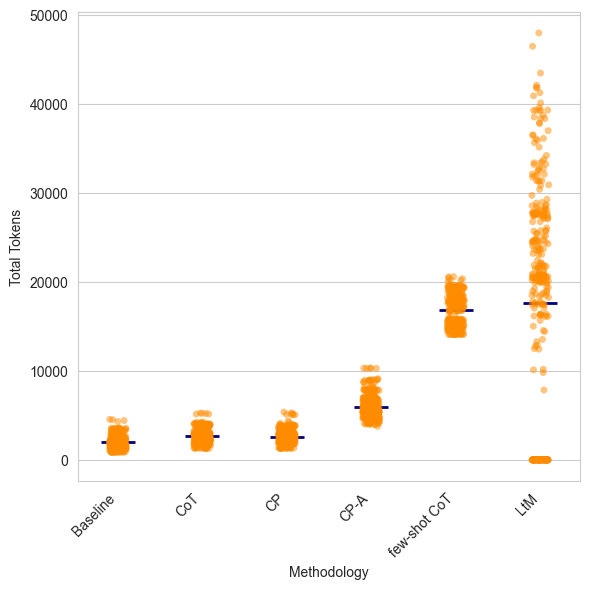

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the figure size and style
plt.figure(figsize=(6, 6))
sns.set_style("whitegrid")

# Create the stripplot for individual data points
ax = sns.stripplot(
    data=df_token,
    x='methodology',
    y='sparql_query_construction_total_tokens',
    order=["Baseline", "CoT", "CP", "CP-A", "few-shot CoT", "LtM"],
    alpha=0.5,
    size=5,
    jitter=True,
    color='darkorange',  # Use color instead of palette
    edgecolor='none',
)

# Calculate means for each methodology
means = df_token.groupby('methodology')['sparql_query_construction_total_tokens'].mean()

# Add horizontal lines for the means
for i, method in enumerate(["Baseline", "CoT", "CP", "CP-A", "few-shot CoT", "LtM"]):
    if method in means:
        mean_val = means[method]
        plt.hlines(y=mean_val, xmin=i-0.2, xmax=i+0.2, colors='navy', linewidth=2)

plt.xlabel('Methodology')
plt.ylabel('Total Tokens')
plt.xticks(rotation=45, ha='right')

# Adjust layout
plt.tight_layout()
plt.show()

/var/folders/cf/q7bl9m0529ncggwfh1ml6k5m0000gn/T/ipykernel_93664/695548835.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(


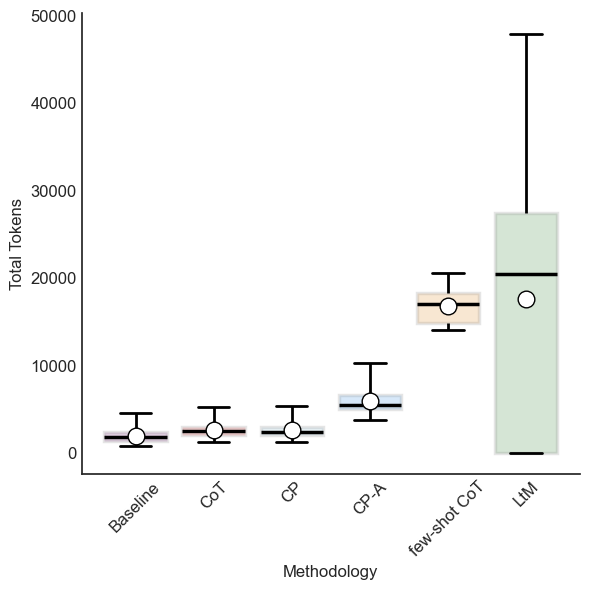

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the figure
plt.style.use('seaborn-v0_8-white')
fig, ax = plt.subplots(figsize=(6, 6))

# Define color palette for all methodologies
plot_palette = {
    "Baseline": "purple",
    "CoT": "red",
    "CP": "skyblue",
    "CP-A": "dodgerblue",
    "few-shot CoT": "darkorange",
    "LtM": "forestgreen"
}

methodology_order = ["Baseline", "CoT", "CP", "CP-A", "few-shot CoT", "LtM"]

bp = sns.boxplot(
    x="methodology", 
    y="sparql_query_construction_total_tokens", 
    data=df_token, 
    ax=ax,
    order=methodology_order,
    palette=plot_palette,
    medianprops={"color": "black", "linewidth": 2.5},
    whiskerprops={"color": "black", "linewidth": 2},
    capprops={"color": "black", "linewidth": 2},
    boxprops={"alpha": 0.2, "edgecolor": "gray", "linewidth": 2.5},
    showfliers=False,
    whis=[0, 100]
)

for method_idx, method_name in enumerate(methodology_order):
    method_data = df_token[df_token["methodology"] == method_name]
    if not method_data.empty:
        mean_value = method_data["sparql_query_construction_total_tokens"].mean()
        ax.plot(method_idx, mean_value, 'o',
                markerfacecolor='white',
                markeredgecolor='black',
                markersize=12,
                markeredgewidth=1,
                zorder=3)

ax.set_xlabel("Methodology", fontsize=12)
ax.set_ylabel("Total Tokens", fontsize=12)
ax.tick_params(axis='x', labelsize=12, rotation=45)
ax.tick_params(axis='y', labelsize=12)
sns.despine(ax=ax)

plt.tight_layout()
plt.show()

In [ ]:
# This code block is used to calculate the mean distribution of tokens for each methodology


# Start with a copy of the original dataframe
df_tokens = df.copy()

# For standard methodologies, filter out rows with NaN values
std_data = df_tokens[df_tokens['methodology'] != 'LtM'].dropna(
    subset=['sparql_query_construction_prompt_tokens', 'sparql_query_construction_completion_tokens']
)

# For LtM methodology, filter out rows with NaN in component columns
ltm_data = df_tokens[df_tokens['methodology'] == 'LtM'].dropna(
    subset=[
        'planning_prompt_tokens', 'planning_completion_tokens',
        'pattern_prompt_tokens', 'pattern_completion_tokens',
        'assembler_prompt_tokens', 'assembler_completion_tokens'
    ]
)

# For LtM, calculate the sum of component tokens
ltm_data['sparql_query_construction_prompt_tokens'] = (
    ltm_data[['planning_prompt_tokens', 'pattern_prompt_tokens', 'assembler_prompt_tokens']]
    .sum(axis=1)
)

ltm_data['sparql_query_construction_completion_tokens'] = (
    ltm_data[['planning_completion_tokens', 'pattern_completion_tokens', 'assembler_completion_tokens']]
    .sum(axis=1)
)

# Combine the filtered dataframes
df_tokens_clean = pd.concat([std_data, ltm_data])

# Calculate mean values for each methodology
token_means = df_tokens_clean.groupby('methodology').agg({
    'sparql_query_construction_prompt_tokens': 'mean',
    'sparql_query_construction_completion_tokens': 'mean'
}).reset_index()

Token usage by methodology:
    methodology  sparql_query_construction_prompt_tokens  \
0      Baseline                              1849.949367   
1           CoT                              2320.906250   
2            CP                              2347.884375   
3          CP-A                              5766.643750   
4  few-shot CoT                             15968.134752   
5           LtM                             24408.629464   

   sparql_query_construction_completion_tokens  total_tokens  
0                                   120.465190   1970.414557  
1                                   309.690625   2630.596875  
2                                   243.915625   2591.800000  
3                                   167.271875   5933.915625  
4                                   820.184397  16788.319149  
5                                   714.424107  25123.053571  


<Figure size 800x600 with 0 Axes>

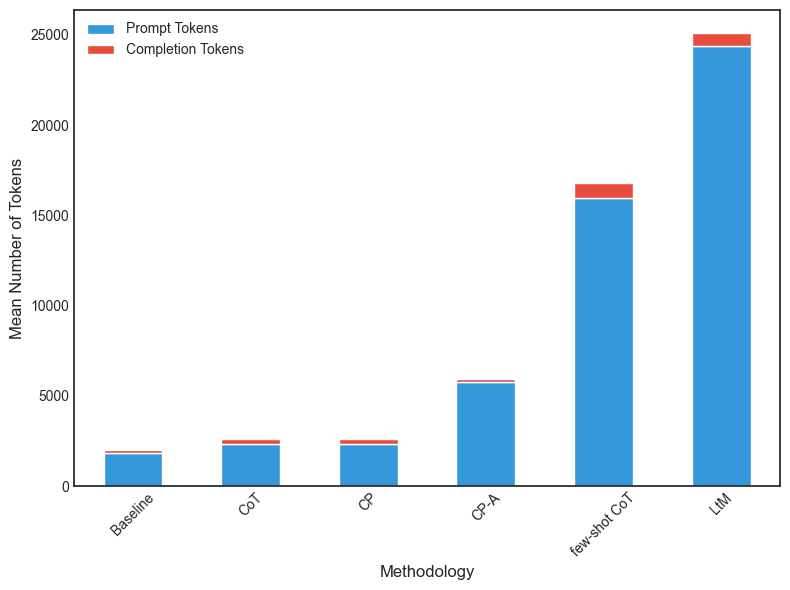

In [52]:
# Create the plot
plt.figure(figsize=(8, 6))
methodology_order = ["Baseline", "CoT", "CP", "CP-A", "few-shot CoT", "LtM"]
token_means = token_means.set_index('methodology').reindex(methodology_order).reset_index()

# Add a column for total tokens
token_means['total_tokens'] = token_means['sparql_query_construction_prompt_tokens'] + token_means['sparql_query_construction_completion_tokens']

# Print the token counts for verification
print("Token usage by methodology:")
print(token_means[['methodology', 'sparql_query_construction_prompt_tokens', 
                  'sparql_query_construction_completion_tokens', 'total_tokens']])

# Create a stacked bar chart
ax = token_means.plot(
    x='methodology',
    y=['sparql_query_construction_prompt_tokens', 'sparql_query_construction_completion_tokens'],
    kind='bar',
    stacked=True,
    color=['#3498db', '#e74c3c'],
    figsize=(8, 6)
)


#plt.title('Average Token Usage by Methodology', fontsize=14)
plt.xlabel('Methodology', fontsize=12)
plt.ylabel('Mean Number of Tokens', fontsize=12)
plt.legend(['Prompt Tokens', 'Completion Tokens'])
plt.xticks(rotation=45)
plt.tight_layout()

In [55]:
latex_table = token_means[['methodology', 'sparql_query_construction_prompt_tokens', 
                          'sparql_query_construction_completion_tokens', 'total_tokens']].to_latex(
    index=False,
    caption="Token Usage by Methodology",
    label="tab:token-usage",
    column_format="lrrr",
    formatters={
        'sparql_query_construction_prompt_tokens': lambda x: f"{x:,.1f}",
        'sparql_query_construction_completion_tokens': lambda x: f"{x:,.1f}",
        'total_tokens': lambda x: f"{x:,.1f}"
    },
    header=['Methodology', 'Prompt Tokens', 'Completion Tokens', 'Total Tokens']
)

print(latex_table)

with open('./plots_multi_run/token_usage_table.tex', 'w') as f:
    f.write(latex_table)

\begin{table}
\caption{Token Usage by Methodology}
\label{tab:token-usage}
\begin{tabular}{lrrr}
\toprule
Methodology & Prompt Tokens & Completion Tokens & Total Tokens \\
\midrule
Baseline & 1,849.9 & 120.5 & 1,970.4 \\
CoT & 2,320.9 & 309.7 & 2,630.6 \\
CP & 2,347.9 & 243.9 & 2,591.8 \\
CP-A & 5,766.6 & 167.3 & 5,933.9 \\
few-shot CoT & 15,968.1 & 820.2 & 16,788.3 \\
LtM & 24,408.6 & 714.4 & 25,123.1 \\
\bottomrule
\end{tabular}
\end{table}



/var/folders/cf/q7bl9m0529ncggwfh1ml6k5m0000gn/T/ipykernel_93664/2818433071.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="methodology", y="syntactically_valid", data=valid_summary, palette="Blues_d",legend=False)


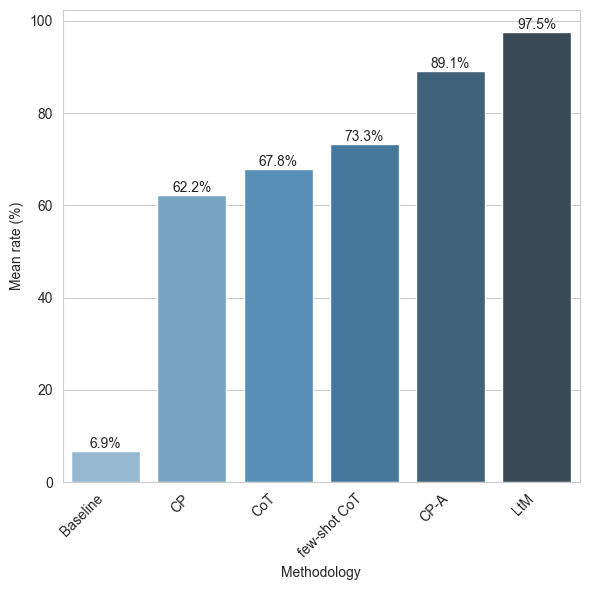

In [32]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
ax = sns.barplot(x="methodology", y="syntactically_valid", data=valid_summary, palette="Blues_d",legend=False)
plt.ylabel("Mean rate (%)")
plt.xlabel("Methodology")
plt.xticks(rotation=45, ha='right', fontsize=10)

for p in ax.patches:
    height = p.get_height()
    plt.text(
        p.get_x() + p.get_width() / 2,
        height,
        f'{height:.1f}%',
        ha='center',
        va='bottom'
    )
plt.tight_layout()
plt.savefig("./plots_multi_run/syntactically_valid_percentage.png", dpi=300, bbox_inches='tight')
plt.show()

In [10]:
df_error = df[df["is_valid_sparql"] == True]

total_passed_queries_to_endpoint = (
    df_error
    .groupby("methodology")
    .size() 
    .reset_index(name="total_passed_queries_to_endpoint")
)

empty_result_counts = (
    df_error[df_error["error_occured_at_endpoint_message"] == "no error, but empty result"]
    .groupby("methodology")
    .size()
    .reset_index(name="empty_result_count")
)

summary = pd.merge(total_passed_queries_to_endpoint, empty_result_counts, on="methodology", how="left")
summary["empty_result_count"] = summary["empty_result_count"].fillna(0)
summary["percentage_empty_result"] = summary["empty_result_count"] / summary["total_passed_queries_to_endpoint"] * 100

print(summary.head(6))

    methodology  total_passed_queries_to_endpoint  empty_result_count  \
0      Baseline                                22                 0.0   
1            CP                               199               136.0   
2          CP-A                               285                97.0   
3           CoT                               217               160.0   
4           LtM                               312                72.0   
5  few-shot CoT                               209               120.0   

   percentage_empty_result  
0                 0.000000  
1                68.341709  
2                34.035088  
3                73.732719  
4                23.076923  
5                57.416268  


/var/folders/cf/q7bl9m0529ncggwfh1ml6k5m0000gn/T/ipykernel_93664/1673740106.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


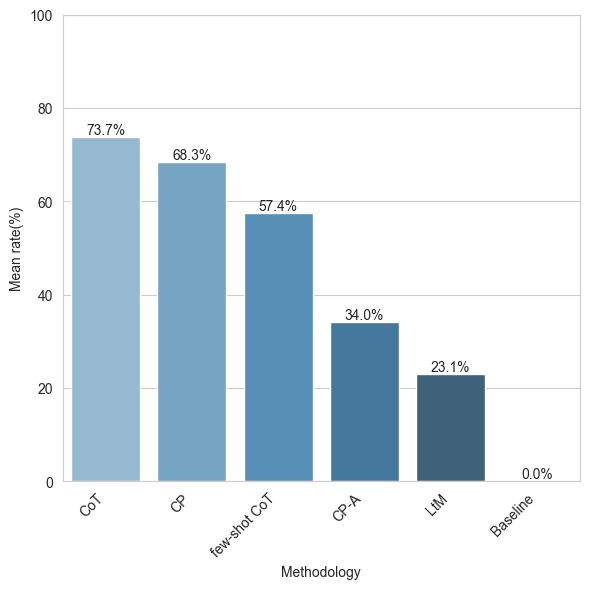

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by percentage for a clearer plot
summary_sorted = summary.sort_values("percentage_empty_result", ascending=False)

plt.figure(figsize=(6, 6))
ax = sns.barplot(
    x="methodology",
    y="percentage_empty_result",
    data=summary_sorted,
    palette="Blues_d"
)
plt.ylabel('Mean rate(%)')
plt.xlabel('Methodology')
#plt.title('Average Percentage of empty result by Methodology\n(Syntactically Correct Queries Only)')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Optionally annotate bars with the percentage
for p in ax.patches:
    height = p.get_height()
    # If height is a fraction, multiply by 100
    plt.text(
        p.get_x() + p.get_width() / 2,
        height,
        f'{height:.1f}%',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.savefig("./plots_multi_run/empty_result.png", dpi=300, bbox_inches='tight')
plt.show()

In [12]:
df_error = df[df["is_valid_sparql"] == True]

total_passed_queries_to_endpoint = (
    df_error
    .groupby("methodology")
    .size() 
    .reset_index(name="total_passed_queries_to_endpoint")
)

timeout_counts = (
    df_error[(df_error["error_occured_at_endpoint_message"] == "The read operation timed out") | 
             (df_error["error_occured_at_endpoint_message"].str.contains("Query timed out after"))]
    .groupby("methodology")
    .size()
    .reset_index(name="timeout_count")
)

timeout_percentages = (
    timeout_counts.merge(total_passed_queries_to_endpoint, on="methodology")
    .assign(timeout_percentage=lambda x: 100 * x.timeout_count / x.total_passed_queries_to_endpoint)
    .sort_values("timeout_percentage")
)

/var/folders/cf/q7bl9m0529ncggwfh1ml6k5m0000gn/T/ipykernel_93664/3665522760.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


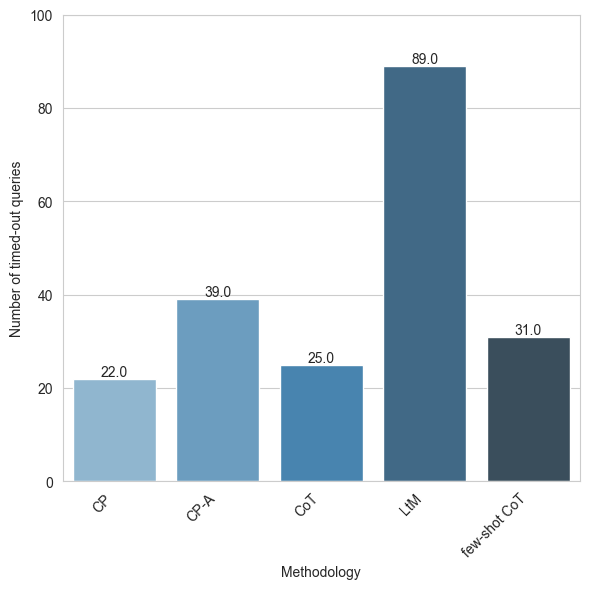

In [13]:

plt.figure(figsize=(6, 6))
ax = sns.barplot(
    x="methodology",
    y="timeout_count",
    data=timeout_counts,
    palette="Blues_d"
)
plt.ylabel('Number of timed-out queries')
plt.xlabel('Methodology')
#plt.title('Number of timed-out queries by Methodology\n(Syntactically Correct Queries Only)')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Optionally annotate bars with the percentage
for p in ax.patches:
    height = p.get_height()
    # If height is a fraction, multiply by 100
    plt.text(
        p.get_x() + p.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.savefig("./plots_multi_run/timeout_counts.png", dpi=300, bbox_inches='tight')
plt.show()

In [14]:
import pandas as pd
import numpy as np

# 1. Filter for valid SPARQL queries
valid_df = df[df["is_valid_sparql"] == True].copy()

# 2. Classify error messages
valid_df["error_type"] = "Error"  # Default classification

# Apply classifications
empty_result_mask = valid_df["error_occured_at_endpoint_message"] == "no error, but empty result"
timeout_mask = valid_df["error_occured_at_endpoint_message"].str.contains("The read operation timed out", na=False) | valid_df["error_occured_at_endpoint_message"].str.contains("Query timed out after", na=False)
no_error_mask = valid_df["error_occured_at_endpoint_message"] == "no error"

valid_df.loc[empty_result_mask, "error_type"] = "Empty Result"
valid_df.loc[timeout_mask, "error_type"] = "Timeout"
valid_df.loc[no_error_mask, "error_type"] = "Result"

# 3. Group by experiment and error type to get counts
long_df = valid_df.groupby(["methodology", "error_type"]).size().reset_index(name="count")

# 4. Get total valid queries per experiment
total_per_exp = valid_df.groupby("methodology").size().reset_index(name="total")

# 5. Merge to calculate percentages
long_df = pd.merge(long_df, total_per_exp, on="methodology")
long_df["percentage"] = (long_df["count"] / long_df["total"]) * 100

# 6. Get unique experiments and error types for plotting
experiments = long_df["methodology"].unique()
error_types = long_df["error_type"].unique()

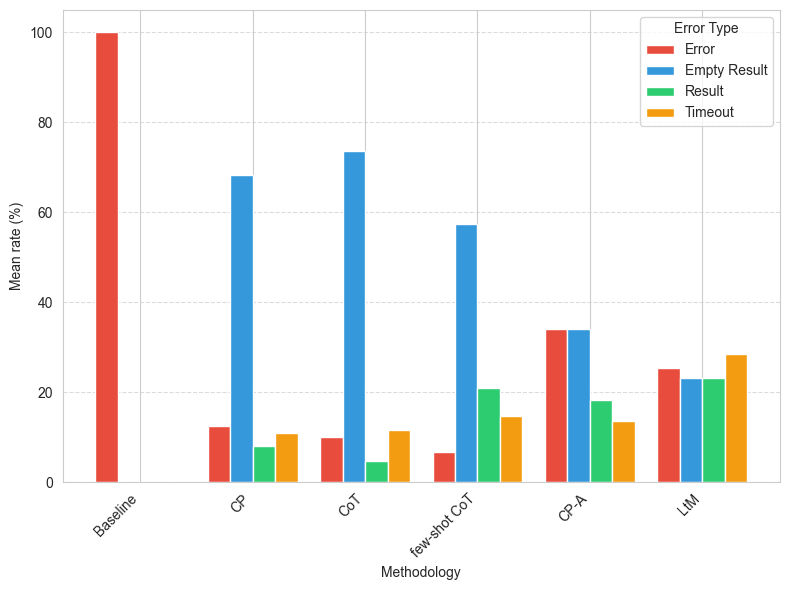

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define your custom order
order = ["Baseline", "CP", "CoT", "few-shot CoT", "CP-A", "LtM"]

long_df = valid_df.groupby(["methodology", "error_type"]).size().reset_index(name="count")
total_per_exp = valid_df.groupby("methodology").size().reset_index(name="total")
long_df = pd.merge(long_df, total_per_exp, on="methodology")
long_df["percentage"] = (long_df["count"] / long_df["total"]) * 100

valid_order = [method for method in order if method in long_df["methodology"].unique()]
experiments = valid_order

error_types = long_df["error_type"].unique()

fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.2
index = np.arange(len(experiments))
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

for i, error_type in enumerate(error_types):
    error_data = long_df[long_df["error_type"] == error_type]
    error_dict = dict(zip(error_data["methodology"], error_data["percentage"]))
    percentages = [error_dict.get(exp, 0) for exp in experiments]
    bars = ax.bar(index + i*bar_width, percentages, bar_width, label=error_type, color=colors[i % len(colors)])

    # for bar, pct in zip(bars, percentages):
    #     ax.text(
    #         bar.get_x() + bar.get_width() / 2,
    #         bar.get_height(),
    #         f'{pct:.1f}%',
    #         ha='center',
    #         va='bottom',
    #         fontsize=8
    #     )

ax.set_xlabel('Methodology')
ax.set_ylabel('Mean rate (%)')
ax.set_xticks(index + bar_width * (len(error_types) - 1) / 2)
ax.set_xticklabels(experiments, rotation=45, ha='right')
ax.legend(title="Error Type")
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("./plots_multi_run/error_types_percentage.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
import os
import json
import pandas as pd
from pathlib import Path
from datetime import datetime


def read_metrics_dataset(path):
    with open(path, 'r') as f:
        data = json.load(f)
    if isinstance(data, dict):
        data = [data]
    return data

base_dir = Path("/Users/sebastian/Documents/Bachelor Thesis/sparql-rag-agent/sparql-rag-agent/experiments/experiments_official")

methodology_mapping = {
    "multi_run_2025-05-02_00-31-21": "CP-A",  
    "multi_run_2025-05-04_00-51-30": "few-shot CoT",     
    "multi_run_2025-05-06_22-14-46": "LtM",
    "multi_run_2025-05-10_14-26-00": "Baseline",
    "multi_run_2025-05-10_18-05-54": "CP",
    "multi_run_2025-05-11_00-21-16": "CoT",
}

multi_run_dirs = [d for d in base_dir.glob("multi_run_*") if d.is_dir()]
print(f"Found {len(multi_run_dirs)} multi-run directories: {[d.name for d in multi_run_dirs]}")

all_metrics_data = []

for multi_run_dir in multi_run_dirs:
    multi_run_name = multi_run_dir.name
    methodology = methodology_mapping.get(multi_run_name, multi_run_name)
    print(f"\nProcessing multi-run: {multi_run_name} (Methodology: {methodology})")
    
    run_dirs = [d for d in multi_run_dir.glob("run_*") if d.is_dir()]
    print(f"Found {len(run_dirs)} run directories")
    
    for run_dir in run_dirs:
        run_name = run_dir.name
        
        eval_dirs = [d for d in run_dir.glob("ev_*") if d.is_dir()]
        
        if not eval_dirs:
            print(f"  × No evaluation directory found in {run_name}")
            continue
            
        for eval_dir in eval_dirs:
            eval_timestamp = eval_dir.name.replace("ev_", "")
            metrics_dataset_file = eval_dir / "metrics_dataset.json"
            
            if not metrics_dataset_file.exists():
                print(f"  × Metrics dataset file not found in {eval_dir.name}")
                continue
                
            print(f"  • Processing {run_name}/{eval_dir.name}")
            
            try:
                metrics_data = read_metrics_dataset(metrics_dataset_file)
                
                for item in metrics_data:
                    item["methodology"] = methodology
                    item["multi_run_dir"] = multi_run_name
                    item["eval_dir"] = eval_dir.name
                    all_metrics_data.append(item)
                    
                print(f"    ✓ Added {len(metrics_data)} items from metrics dataset")
                
            except Exception as e:
                print(f"  × Error processing {metrics_dataset_file}: {e}")

df_metrics = pd.DataFrame(all_metrics_data)
    

Found 6 multi-run directories: ['multi_run_2025-05-11_00-21-16', 'multi_run_2025-05-04_00-51-30', 'multi_run_2025-05-10_18-05-54', 'multi_run_2025-05-06_22-14-46', 'multi_run_2025-05-10_14-26-00', 'multi_run_2025-05-02_00-31-21']

Processing multi-run: multi_run_2025-05-11_00-21-16 (Methodology: CoT)
Found 10 run directories
  • Processing run_2/ev_2025-05-11_00-28-57
    ✓ Added 1 items from metrics dataset
  • Processing run_5/ev_2025-05-11_02-25-26
    ✓ Added 1 items from metrics dataset
  • Processing run_4/ev_2025-05-11_01-22-23
    ✓ Added 1 items from metrics dataset
  • Processing run_3/ev_2025-05-11_00-57-28
    ✓ Added 1 items from metrics dataset
  • Processing run_10/ev_2025-05-12_04-07-17
    ✓ Added 1 items from metrics dataset
  • Processing run_6/ev_2025-05-12_02-40-23
    ✓ Added 1 items from metrics dataset
  • Processing run_1/ev_2025-05-12_00-25-08
    ✓ Added 1 items from metrics dataset
  • Processing run_8/ev_2025-05-11_09-54-17
    ✓ Added 1 items from metrics 

In [17]:
metrics_avg = df_metrics.groupby('methodology').agg({
    'SP-BLEU': 'mean',
    'METEOR': 'mean',
    'avg_result_excluding_empty_result_precision': 'mean',
    'avg_result_excluding_empty_result_recall': 'mean',
    'avg_result_excluding_empty_result_f1': 'mean'
}).reset_index()

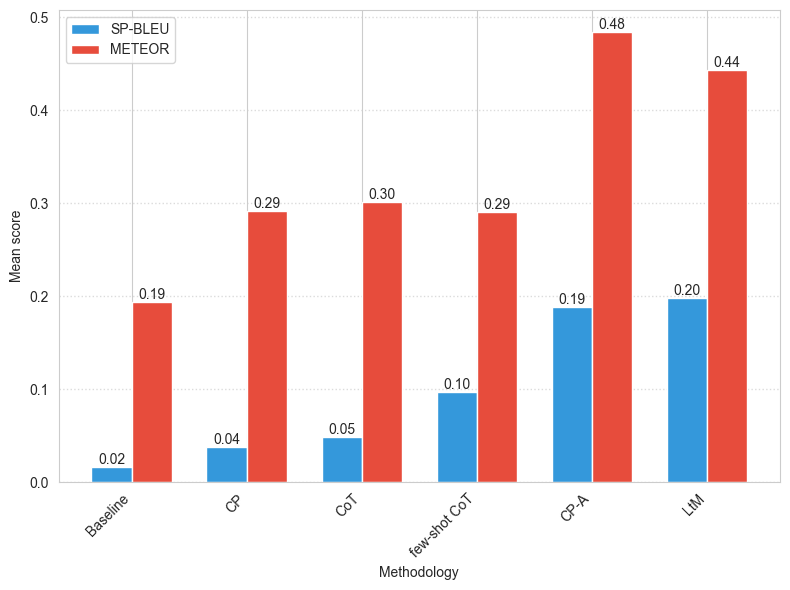

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define your custom order
order = ["Baseline", "CP", "CoT", "few-shot CoT", "CP-A", "LtM"]

# Filter to methodologies that exist in your data
valid_order = [method for method in order if method in metrics_avg['methodology'].values]

# Convert to categorical type to ensure proper ordering
metrics_avg['methodology'] = pd.Categorical(metrics_avg['methodology'], categories=valid_order, ordered=True)
metrics_avg = metrics_avg.sort_values('methodology')

# Get x values
methodologies = metrics_avg['methodology']

# Setup figure
fig, ax = plt.subplots(figsize=(8, 6))

# Set width of bars
bar_width = 0.35
index = np.arange(len(methodologies))

# Create bars
ax.bar(index - bar_width/2, metrics_avg['SP-BLEU'], bar_width, label='SP-BLEU', color='#3498db')
ax.bar(index + bar_width/2, metrics_avg['METEOR'], bar_width, label='METEOR', color='#e74c3c')

# Add score labels on top of each bar (without percentage symbol)
for p in ax.patches:
    height = p.get_height()
    plt.text(
        p.get_x() + p.get_width() / 2,
        height,
        f'{height:.2f}',  
        ha='center',
        va='bottom'
    )

# Labels and legend
ax.set_xlabel('Methodology')
ax.set_ylabel('Mean score')  # Updated to remove percentage reference
ax.set_xticks(index)
ax.set_xticklabels(methodologies, rotation=45, ha='right', fontsize=10)
ax.legend()
ax.grid(axis='y', linestyle=':', linewidth=1, alpha=0.7)

plt.tight_layout()
plt.savefig("./plots_multi_run/sp_bleu_meteor_avg_bars.png", dpi=300, bbox_inches='tight')
plt.show()

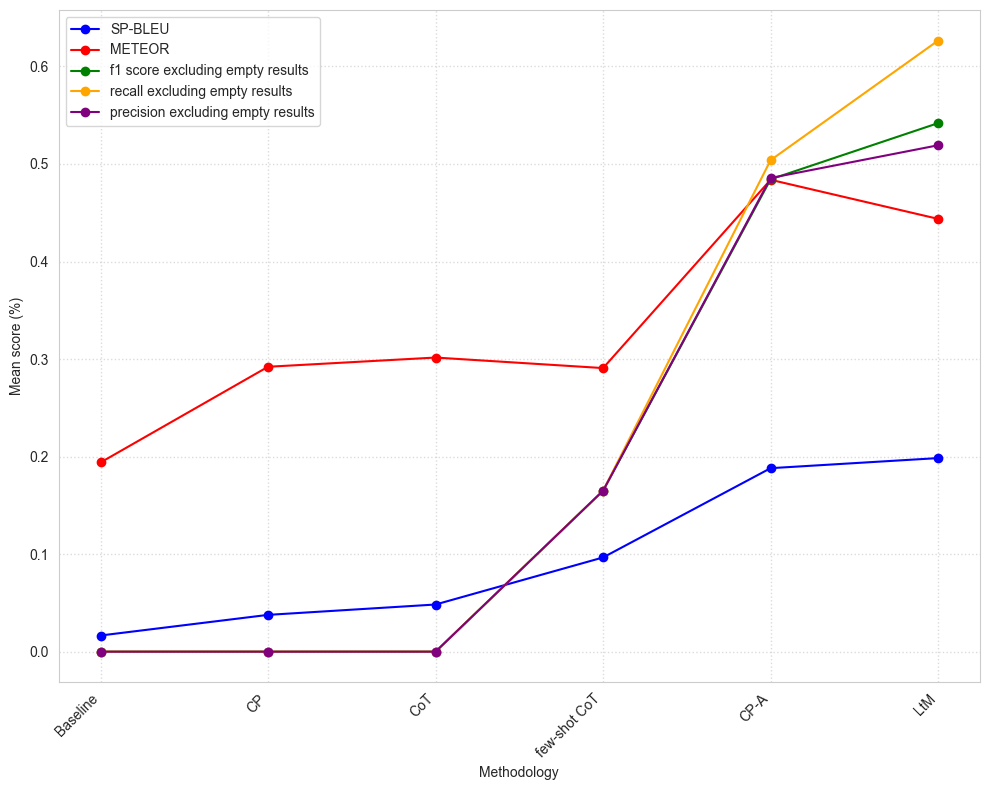

In [19]:
import matplotlib.pyplot as plt

x = metrics_avg['methodology']

plt.figure(figsize=(10, 8))
plt.plot(x, metrics_avg['SP-BLEU'], marker='o', color='blue', label='SP-BLEU')
plt.plot(x, metrics_avg['METEOR'], marker='o', color='red', label='METEOR')
plt.plot(x, metrics_avg['avg_result_excluding_empty_result_f1'], marker='o', color='green', label='f1 score excluding empty results')
plt.plot(x, metrics_avg['avg_result_excluding_empty_result_recall'], marker='o', color='orange', label='recall excluding empty results')
plt.plot(x, metrics_avg['avg_result_excluding_empty_result_precision'], marker='o', color='purple', label='precision excluding empty results')

plt.xlabel('Methodology')
#plt.title('Average metrics excluding empty results')
plt.ylabel('Mean score (%)')
plt.legend()
plt.grid(True, linestyle=':', linewidth=1, alpha=0.7) 
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.savefig("./plots_multi_run/combined_avg_metrics.png", dpi=300, bbox_inches='tight')
plt.show()

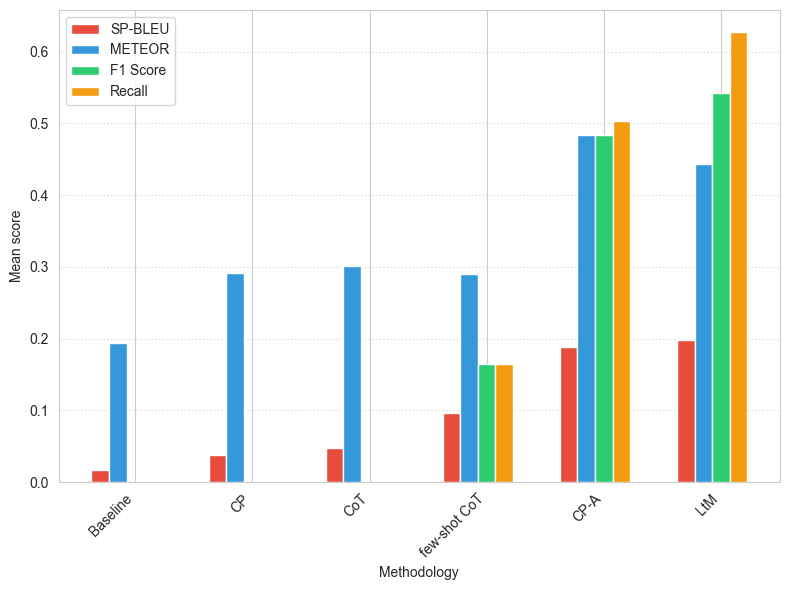

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define your custom order
order = ["Baseline", "CP", "CoT", "few-shot CoT", "CP-A", "LtM"]

# Filter to methodologies that exist in your data
valid_order = [method for method in order if method in metrics_avg['methodology'].values]

# Convert to categorical type to ensure proper ordering
metrics_avg['methodology'] = pd.Categorical(metrics_avg['methodology'], categories=valid_order, ordered=True)
metrics_avg = metrics_avg.sort_values('methodology')

# Define metrics to plot
metrics = [
    'SP-BLEU', 
    'METEOR', 
    'avg_result_excluding_empty_result_f1',
    'avg_result_excluding_empty_result_recall', 
    'avg_result_excluding_empty_result_precision'
]

# Define nicer labels for the legend
metric_labels = [
    'SP-BLEU', 
    'METEOR', 
    'F1 Score', 
    'Recall', 
    'Precision'
]

# Setup figure
fig, ax = plt.subplots(figsize=(8, 6))

# Set width of bars
bar_width = 0.15
index = np.arange(len(valid_order))
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

# Create bars for each metric
for i, (metric, label, color) in enumerate(zip(metrics, metric_labels, colors)):
    values = [metrics_avg[metrics_avg['methodology'] == exp][metric].values[0] for exp in valid_order]
    ax.bar(index + i*bar_width - bar_width*2, values, bar_width, label=label, color=color)
    
    # # Add value labels on top of each bar
    # for j, value in enumerate(values):
    #     ax.text(index[j] + i*bar_width - bar_width*2, value, f'{value:.2f}', 
    #             ha='center', va='bottom', fontsize=8)

# Labels and legend
ax.set_xlabel('Methodology')
ax.set_ylabel('Mean score')
ax.set_xticks(index)
ax.set_xticklabels(valid_order, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle=':', linewidth=1, alpha=0.7)

plt.tight_layout()
plt.savefig("./plots_multi_run/combined_avg_metrics_bars_excluding_empty_result.png", dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # Define your custom order
# order = ["Baseline", "CP", "CoT", "CoT few shot", "CP-A", "LtM"]

# # Filter to methodologies that exist in your data
# valid_order = [method for method in order if method in metrics_avg['methodology'].values]

# # Convert to categorical type to ensure proper ordering
# metrics_avg['methodology'] = pd.Categorical(metrics_avg['methodology'], categories=valid_order, ordered=True)
# metrics_avg = metrics_avg.sort_values('methodology')

# # Define metrics to plot
# metrics = [
#     'avg_result_excluding_empty_result_f1',
#     'avg_result_excluding_empty_result_recall', 
#     'avg_result_excluding_empty_result_precision'
# ]

# # Define nicer labels for the legend
# metric_labels = [
#     'F1 Score', 
#     'Recall', 
#     'Precision'
# ]

# # Setup figure
# fig, ax = plt.subplots(figsize=(8, 6))

# # Set width of bars
# bar_width = 0.15
# index = np.arange(len(valid_order))
# colors = ['#e74c3c', '#3498db', '#2ecc71']

# # Create bars for each metric
# for i, (metric, label, color) in enumerate(zip(metrics, metric_labels, colors)):
#     values = [metrics_avg[metrics_avg['methodology'] == exp][metric].values[0] for exp in valid_order]
#     ax.bar(index + i*bar_width - bar_width*2, values, bar_width, label=label, color=color)
    
#     # # Add value labels on top of each bar
#     # for j, value in enumerate(values):
#     #     ax.text(index[j] + i*bar_width - bar_width*2, value, f'{value:.2f}', 
#     #             ha='center', va='bottom', fontsize=8)

# # Labels and legend
# ax.set_xlabel('Methodology')
# ax.set_ylabel('Mean score')
# ax.set_xticks(index)
# ax.set_xticklabels(valid_order, rotation=45, ha='right')
# ax.legend()
# ax.grid(axis='y', linestyle=':', linewidth=1, alpha=0.7)

# plt.tight_layout()
# plt.savefig("./plots_multi_run/combined_avg_metrics_bars_excluding_empty_result.png", dpi=300, bbox_inches='tight')
# plt.show()

In [22]:
# Create a table with the selected metrics
table_df = metrics_avg[['methodology'] + metrics].copy()

# Rename columns for the table
rename_dict = dict(zip(metrics, metric_labels))
rename_dict['avg_result_excluding_empty_result_f1'] = 'F1 Score'
rename_dict['avg_result_excluding_empty_result_recall'] = 'Recall'
rename_dict['avg_result_excluding_empty_result_precision'] = 'Precision'
table_df = table_df.rename(columns=rename_dict)

# Format numbers to 2 decimal places
for col in metric_labels:
    table_df[col] = table_df[col].map(lambda x: f'{x:.2f}')

# Create LaTeX table
latex_table = table_df.to_latex(index=False, escape=False)

# Make the table look better for LaTeX
latex_table = latex_table.replace('tabular}{lrrrrr}', 'tabular}{l|rrrrr}')
latex_table = latex_table.replace('\\begin{table}', '\\begin{table}[ht]\n\\centering')
latex_table = latex_table.replace('\\end{table}', '\\caption{Performance metrics by methodology}\n\\label{tab:performance_metrics}\n\\end{table}')

# Print LaTeX code that can be copied
print("LaTeX table code:")
print(latex_table)

# Also save to file
with open("./plots_multi_run/metrics_table.tex", "w") as f:
    f.write(latex_table)

print("LaTeX table saved to ./plots_multi_run/metrics_table.tex")

LaTeX table code:
\begin{tabular}{llllll}
\toprule
methodology & SP-BLEU & METEOR & F1 Score & Recall & Precision \\
\midrule
Baseline & 0.02 & 0.19 & 0.00 & 0.00 & 0.00 \\
CP & 0.04 & 0.29 & 0.00 & 0.00 & 0.00 \\
CoT & 0.05 & 0.30 & 0.00 & 0.00 & 0.00 \\
few-shot CoT & 0.10 & 0.29 & 0.16 & 0.16 & 0.16 \\
CP-A & 0.19 & 0.48 & 0.48 & 0.50 & 0.49 \\
LtM & 0.20 & 0.44 & 0.54 & 0.63 & 0.52 \\
\bottomrule
\end{tabular}

LaTeX table saved to ./plots_multi_run/metrics_table.tex


/var/folders/cf/q7bl9m0529ncggwfh1ml6k5m0000gn/T/ipykernel_93664/3158415585.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


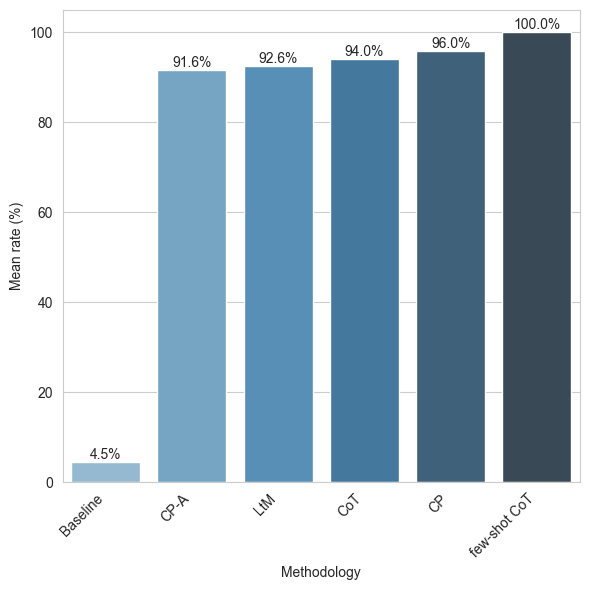

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summarize percentage of correct predicted endpoints per methodology
target_endpoint_summary = (
    valid_df.groupby("methodology")["predicted_endpoint_or_federated_endpoint"]
        .agg(total="size", n_valid="sum")
        .assign(percentage=lambda x: 100 * x.n_valid / x.total)
        .reset_index()
        .sort_values("percentage", ascending=True)
)

plt.figure(figsize=(6, 6))
ax = sns.barplot(
    x="methodology",
    y="percentage",
    data=target_endpoint_summary,
    palette="Blues_d"
)
plt.ylabel("Mean rate (%)")
plt.xlabel("Methodology")
plt.xticks(rotation=45, ha='right', fontsize=10)

# Annotate bars with the percentage
for p in ax.patches:
    height = p.get_height()
    plt.text(
        p.get_x() + p.get_width() / 2,
        height,
        f'{height:.1f}%',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.savefig("./plots_multi_run/percentage_correct_target_or_federated_endpoint.png", dpi=300, bbox_inches='tight')
plt.show()

/var/folders/cf/q7bl9m0529ncggwfh1ml6k5m0000gn/T/ipykernel_93664/1159339080.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


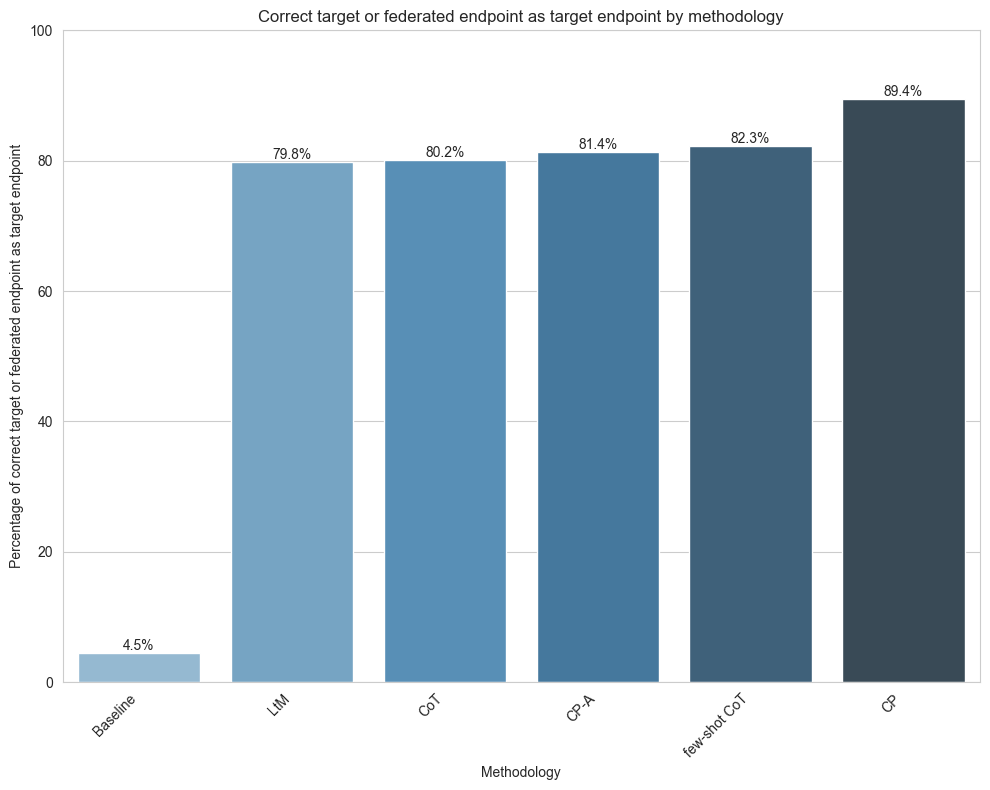

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summarize percentage of correct predicted endpoints per methodology
target_endpoint_summary = (
    valid_df.groupby("methodology")["predicted_endpoint_equal_to_target_endpoint"]
        .agg(total="size", n_valid="sum")
        .assign(percentage=lambda x: 100 * x.n_valid / x.total)
        .reset_index()
        .sort_values("percentage", ascending=True)
)

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x="methodology",
    y="percentage",
    data=target_endpoint_summary,
    palette="Blues_d"
)

plt.ylabel('Percentage of correct target or federated endpoint as target endpoint')
plt.xlabel('Methodology')
plt.title('Correct target or federated endpoint as target endpoint by methodology')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0, 100)

# Annotate bars with the percentage
for p in ax.patches:
    height = p.get_height()
    plt.text(
        p.get_x() + p.get_width() / 2,
        height,
        f'{height:.1f}%',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
#plt.savefig("./plots_multi_run/percentage_correct_target_or_federated_endpoint.png", dpi=300, bbox_inches='tight')
plt.show()